# This file applies pre-trained models (LBPH, Eigenfaces and Fisherfaces) to the test set.
# Every cell shows the results of the respective model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
from google.colab.patches import cv2_imshow
import pickle
import os
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


______________________________________________________________________________________
# **LOCAL BINARY PATTERN HISTOGRAMS :**
______________________________________________________________________________________

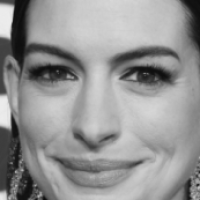

guess: anne-hathaway    expected: anne_hatheway    distance: 36.98    angle: 0.0 °


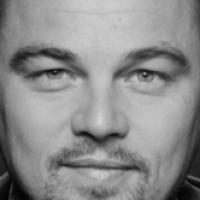

guess: leonardo-dicaprio    expected: leo_dicaprio    distance: 32.965    angle: 0.0 °


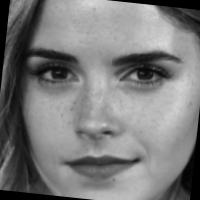

guess: emilia-clarke    expected: emma_watson    distance: 50.581    angle: -6.089 °


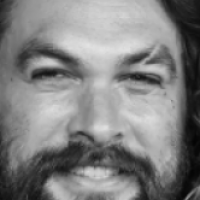

guess: jason-momoa    expected: jason_momoa    distance: 43.678    angle: -6.089 °


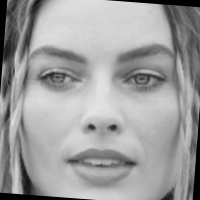

guess: emilia-clarke    expected: margot_robbie    distance: 47.236    angle: -4.332 °


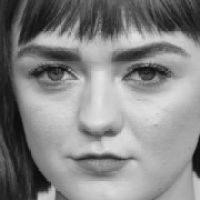

guess: sophie-turner    expected: maisie_williams    distance: 57.487    angle: 0.0 °


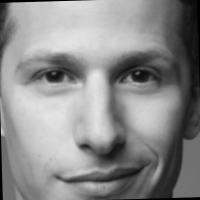

guess: andy-samberg    expected: andy_samberg    distance: 49.825    angle: 1.66 °


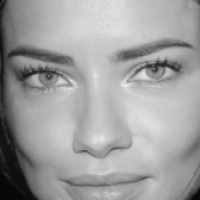

guess: adriana-lima    expected: adriana_lima    distance: 30.71    angle: 1.66 °


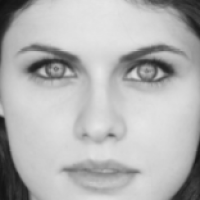

guess: alexandra-daddario    expected: alexandra_daddario    distance: 46.178    angle: 1.66 °


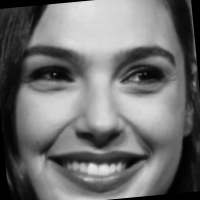

guess: gal-gadot    expected: gal_gadot    distance: 32.45    angle: 5.332 °


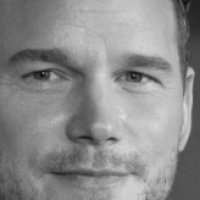

guess: chris-pratt    expected: chris_pratt    distance: 41.496    angle: 5.332 °


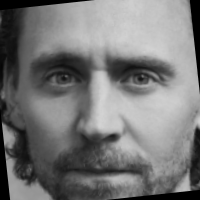

guess: tom-hiddleston    expected: tom_hiddlestone    distance: 47.364    angle: 6.147 °


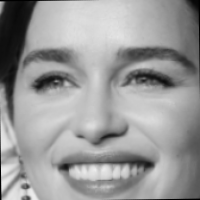

guess: emilia-clarke    expected: emilia_clarke    distance: 48.592    angle: 0.818 °


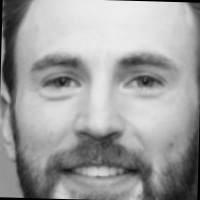

guess: chris-evans    expected: chris_evans    distance: 50.635    angle: -1.569 °


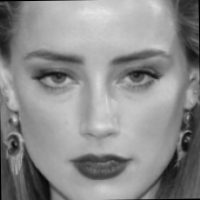

guess: amber-heard    expected: amber_heard    distance: 46.616    angle: 0.843 °


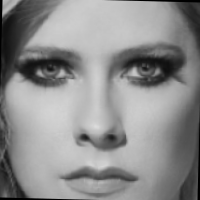

guess: gal-gadot    expected: avril_lavigne    distance: 46.616    angle: -1.469 °


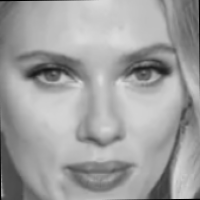

guess: gal-gadot    expected: scarlett_johanneson    distance: 55.674    angle: 0.725 °


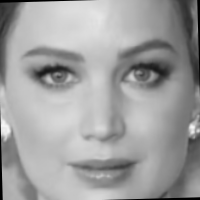

guess: amber-heard    expected: jennifer_lawrence    distance: 51.257    angle: 1.591 °


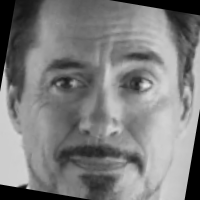

guess: robert-downey-jr    expected: robert_d_junior    distance: 57.666    angle: -9.605 °


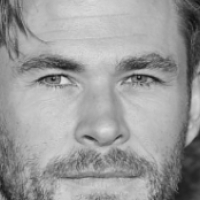

guess: chris-hemsworth    expected: chris_hemsworth    distance: 37.12    angle: -9.605 °


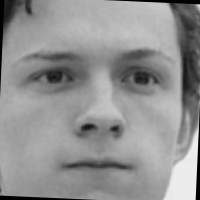

guess: tom-holland    expected: tom_holland    distance: 46.834    angle: -2.564 °


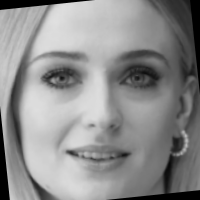

guess: sophie-turner    expected: sophie_turner    distance: 59.036    angle: 5.964 °


In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
recognizer= cv2.face.LBPHFaceRecognizer_create()
recognizer.read("/content/drive/MyDrive/CV_Project/recognizers/face-trainer-LBPH.yml")

labels = {"person_name": 1}
with open("/content/drive/MyDrive/CV_Project/pickles/face-labels-LBPH.pickle", 'rb') as f:
  og_labels = pickle.load(f)
  labels = {v: k for k, v in og_labels.items()}

BASE_DIR = os.path.dirname("/content/drive/MyDrive/CV_Project/camera LBPH.ipynb")
image_dir = os.path.join(BASE_DIR, "test_images")
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith("png") or file.endswith("jpg"):
            path = os.path.join(root, file)

            frame = cv2.imread(path)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) != 0:
                #cv2_imshow(frame)
                for (x, y, width, height) in faces:
                    cv2.rectangle(frame, (x, y), (x + width, y + height),(255, 255, 255), 3)

                    roi_gray = gray[y:y+height, x:x+width]
                    roi_res = cv2.resize(roi_gray, (200,200), interpolation=cv2.INTER_AREA)
                  
                    for (x, y, width, height) in faces:
                      eyes = eye_cascade.detectMultiScale(roi_gray[y:(y + height), x:(x + width)], 1.3, 6)
                      index = 0
                      eye_1 = [None, None, None, None]
                      eye_2 = [None, None, None, None]
                      for (ex, ey, ew, eh) in eyes:
                        if index == 0:
                          eye_1 = [ex, ey, ew, eh]
                        elif index == 1:
                          eye_2 = [ex, ey, ew, eh]
                        cv2.rectangle(roi_gray[y:(y + height), x:(x + width)], (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 1)
                        index = index + 1
                        if (eye_1[0] is not None) and (eye_2[0] is not None):
                          if eye_1[0] < eye_2[0]:
                            left_eye = eye_1
                            right_eye = eye_2
                          else:
                            left_eye = eye_2
                            right_eye = eye_1

                          left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
                          right_eye_center = (int(right_eye[0] + (right_eye[2] / 2)), int(right_eye[1] + (right_eye[3] / 2)))

                          left_eye_x = left_eye_center[0]
                          left_eye_y = left_eye_center[1]
                          right_eye_x = right_eye_center[0]
                          right_eye_y = right_eye_center[1]

                          delta_x = right_eye_x - left_eye_x
                          delta_y = right_eye_y - left_eye_y

                          if delta_x != 0:
                            angle = np.arctan(delta_y / delta_x)

                          # Converting radians to degrees
                          angle = (angle * 180) / np.pi

                          if angle > 3:
                            image_center = tuple(np.array(roi_res.shape[1::-1]) / 2)
                            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
                            result = cv2.warpAffine(roi_res, rot_mat, roi_res.shape[1::-1], flags=cv2.INTER_LINEAR)
                            roi_res=result
                          elif angle < -3:
                            image_center = tuple(np.array(roi_res.shape[1::-1]) / 2)
                            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
                            result = cv2.warpAffine(roi_res, rot_mat, roi_res.shape[1::-1], flags=cv2.INTER_LINEAR)
                            roi_res=result
                          else:
                            image_center = tuple(np.array(roi_res.shape[1::-1]) / 2)
                            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
                            result = cv2.warpAffine(roi_res, rot_mat, roi_res.shape[1::-1], flags=cv2.INTER_LINEAR)
                            roi_res=result

                    cv2_imshow(roi_res)

                    id_, conf = recognizer.predict(roi_res) #conf = distance of the face from the training set (chi-sqr)
                    if conf >= 4 and conf <= 71:
                      name = labels[id_]
                      print("guess:", name[5:], "  ", "expected:", file[:-4] ,"  ", "distance:", round(conf,3), "  ", "angle:", round(angle,3), "°")
                    
                    else:
                      name = "unknown"
                      print(name, "  ", "expected:", file[:-4])

______________________________________________________________________________________
# **EIGENFACES :**
______________________________________________________________________________________

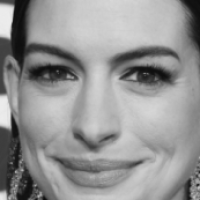

guess: maisie-williams    expected: anne_hatheway    distance: 8027.066    angle: 0.0 °


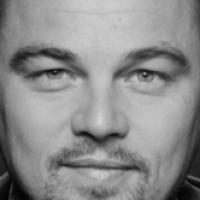

guess: leonardo-dicaprio    expected: leo_dicaprio    distance: 5292.135    angle: 0.0 °


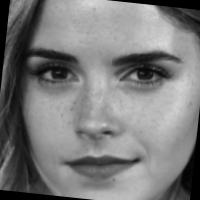

guess: sophie-turner    expected: emma_watson    distance: 7935.575    angle: -6.089 °


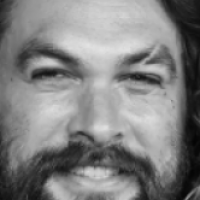

guess: chris-pratt    expected: jason_momoa    distance: 7775.097    angle: -6.089 °


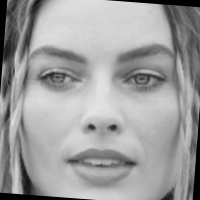

guess: maisie-williams    expected: margot_robbie    distance: 8200.545    angle: -4.332 °


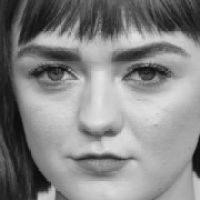

guess: emma-watson    expected: maisie_williams    distance: 8683.332    angle: 0.0 °


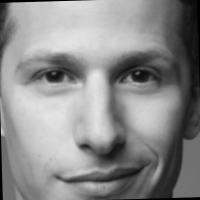

guess: gal-gadot    expected: andy_samberg    distance: 7253.298    angle: 1.66 °


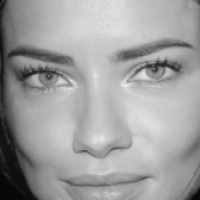

guess: adriana-lima    expected: adriana_lima    distance: 5031.961    angle: 1.66 °


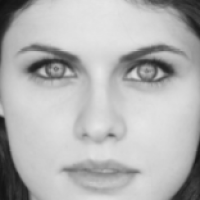

guess: alexandra-daddario    expected: alexandra_daddario    distance: 6701.662    angle: 1.66 °


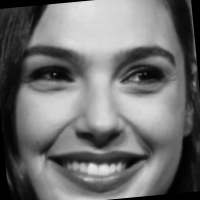

guess: gal-gadot    expected: gal_gadot    distance: 6610.713    angle: 5.332 °


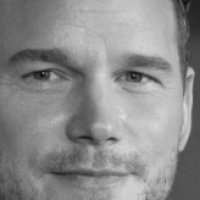

guess: andy-samberg    expected: chris_pratt    distance: 6759.12    angle: 5.332 °


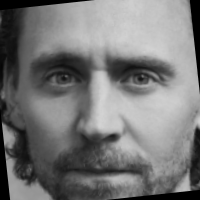

guess: chris-pratt    expected: tom_hiddlestone    distance: 8650.238    angle: 6.147 °


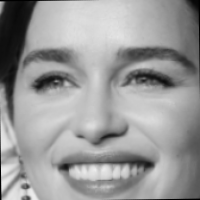

guess: andy-samberg    expected: emilia_clarke    distance: 7776.417    angle: 0.818 °


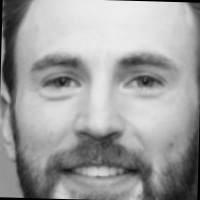

guess: robert-downey-jr    expected: chris_evans    distance: 7754.213    angle: -1.569 °


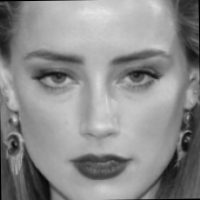

guess: chris-hemsworth    expected: amber_heard    distance: 7379.731    angle: 0.843 °


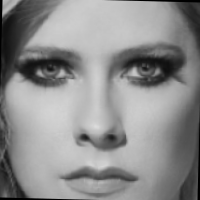

guess: gal-gadot    expected: avril_lavigne    distance: 7206.157    angle: -1.469 °


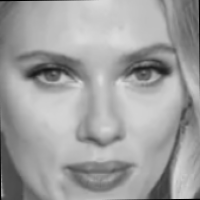

guess: alexandra-daddario    expected: scarlett_johanneson    distance: 6258.161    angle: 0.725 °


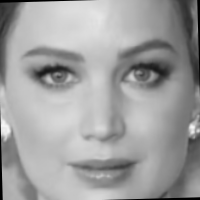

guess: amber-heard    expected: jennifer_lawrence    distance: 5552.513    angle: 1.591 °


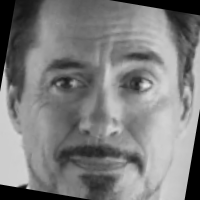

unknown    expected: robert_d_junior


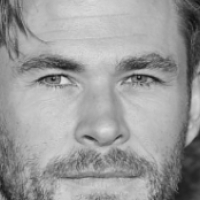

guess: sophie-turner    expected: chris_hemsworth    distance: 6712.269    angle: -9.605 °


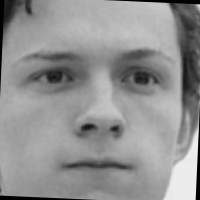

guess: tom-holland    expected: tom_holland    distance: 7118.011    angle: -2.564 °


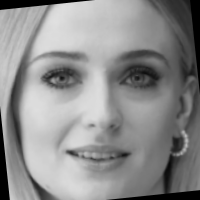

guess: sophie-turner    expected: sophie_turner    distance: 8838.325    angle: 5.964 °


In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
recognizer= cv2.face.EigenFaceRecognizer_create()
recognizer.read("/content/drive/MyDrive/CV_Project/recognizers/face-trainer-Eigen.yml")

labels = {"person_name": 1}
with open("/content/drive/MyDrive/CV_Project/pickles/face-labels-Eigen.pickle", 'rb') as f:
  og_labels = pickle.load(f)
  labels = {v: k for k, v in og_labels.items()}

BASE_DIR = os.path.dirname("/content/drive/MyDrive/CV_Project/camera Eigen.ipynb")
image_dir = os.path.join(BASE_DIR, "test_images")
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith("png") or file.endswith("jpg"):
            path = os.path.join(root, file)

            frame = cv2.imread(path)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) != 0:
                for (x, y, width, height) in faces:
                    cv2.rectangle(frame, (x, y), (x + width, y + height), (255, 255, 255), 3)
                    roi_gray = gray[y:y+height, x:x+width]
                    roi_res = cv2.resize(roi_gray, (200,200), interpolation=cv2.INTER_AREA)
                  
                    for (x, y, width, height) in faces:
                      eyes = eye_cascade.detectMultiScale(roi_gray[y:(y + height), x:(x + width)], 1.3, 6)
                      index = 0
                      eye_1 = [None, None, None, None]
                      eye_2 = [None, None, None, None]
                      for (ex, ey, ew, eh) in eyes:
                            if index == 0:
                                eye_1 = [ex, ey, ew, eh]
                            elif index == 1:
                                eye_2 = [ex, ey, ew, eh]
                            cv2.rectangle(roi_gray[y:(y + height), x:(x + width)], (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 1)
                            index = index + 1
                            if (eye_1[0] is not None) and (eye_2[0] is not None):
                                if eye_1[0] < eye_2[0]:
                                    left_eye = eye_1
                                    right_eye = eye_2
                                else:
                                    left_eye = eye_2
                                    right_eye = eye_1
                                left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))

                                right_eye_center = (int(right_eye[0] + (right_eye[2] / 2)), int(right_eye[1] + (right_eye[3] / 2)))

                                left_eye_x = left_eye_center[0]
                                left_eye_y = left_eye_center[1]
                                right_eye_x = right_eye_center[0]
                                right_eye_y = right_eye_center[1]

                                delta_x = right_eye_x - left_eye_x
                                delta_y = right_eye_y - left_eye_y

                                if delta_x != 0:
                                  angle = np.arctan(delta_y / delta_x)

                                # Converting radians to degrees
                                angle = (angle * 180) / np.pi

                                if angle > 5:
                                    image_center = tuple(np.array(roi_res.shape[1::-1]) / 2)
                                    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
                                    result = cv2.warpAffine(roi_res, rot_mat, roi_res.shape[1::-1], flags=cv2.INTER_LINEAR)
                                    roi_res=result
                                elif angle < -5:
                                    image_center = tuple(np.array(roi_res.shape[1::-1]) / 2)
                                    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
                                    result = cv2.warpAffine(roi_res, rot_mat, roi_res.shape[1::-1], flags=cv2.INTER_LINEAR)
                                    roi_res=result
                                else:
                                    image_center = tuple(np.array(roi_res.shape[1::-1]) / 2)
                                    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
                                    result = cv2.warpAffine(roi_res, rot_mat, roi_res.shape[1::-1], flags=cv2.INTER_LINEAR)
                                    roi_res=result

                    cv2_imshow(roi_res)

                    id_, conf = recognizer.predict(roi_res) #conf = distance of the face from the training set (euclidean)
                    if conf >= 4 and conf <= 9000:
                        name = labels[id_]
                        print("guess:", name[5:], "  ", "expected:", file[:-4] ,"  ", "distance:", round(conf,3), "  ", "angle:", round(angle,3), "°")
                    else:
                        name = "unknown"
                        print(name, "  ", "expected:", file[:-4])

______________________________________________________________________________________
# **FISHERFACES :**
______________________________________________________________________________________

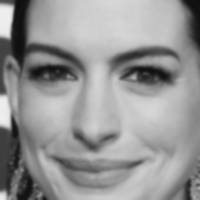

guess: emilia-clarke    expected: anne_hatheway    distance: 111.469    angle: 0.0 °


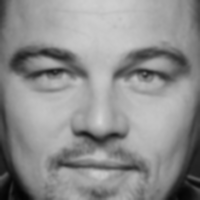

guess: leonardo-dicaprio    expected: leo_dicaprio    distance: 92.202    angle: 0.0 °


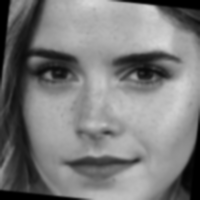

guess: alexandra-daddario    expected: emma_watson    distance: 170.682    angle: -6.089 °


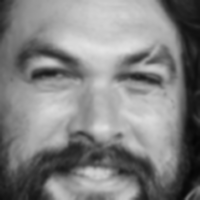

guess: andy-samberg    expected: jason_momoa    distance: 133.143    angle: -6.089 °


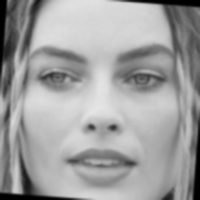

guess: andy-samberg    expected: margot_robbie    distance: 168.378    angle: -4.332 °


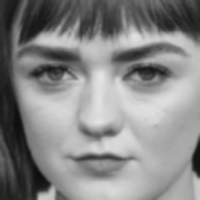

guess: scarlett-johansson    expected: maisie_williams    distance: 156.683    angle: 0.0 °


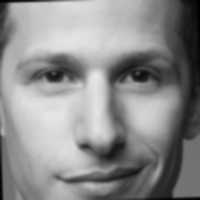

guess: andy-samberg    expected: andy_samberg    distance: 181.949    angle: 1.66 °


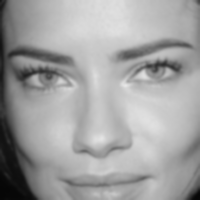

guess: emilia-clarke    expected: adriana_lima    distance: 91.317    angle: 1.66 °


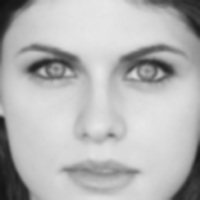

guess: alexandra-daddario    expected: alexandra_daddario    distance: 102.201    angle: 1.66 °


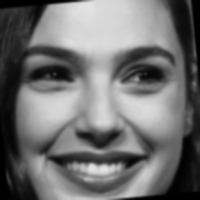

guess: tom-holland    expected: gal_gadot    distance: 153.995    angle: 5.332 °


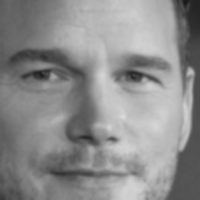

guess: leonardo-dicaprio    expected: chris_pratt    distance: 78.559    angle: 5.332 °


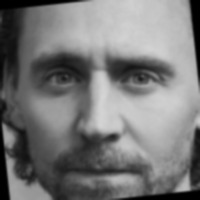

guess: andy-samberg    expected: tom_hiddlestone    distance: 191.397    angle: 6.147 °


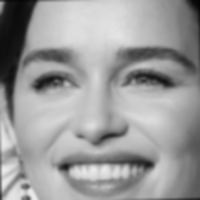

guess: andy-samberg    expected: emilia_clarke    distance: 156.003    angle: 0.818 °


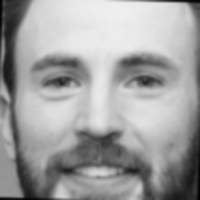

guess: alexandra-daddario    expected: chris_evans    distance: 177.935    angle: -1.569 °


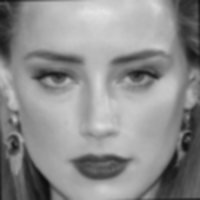

guess: jennifer-lawrence    expected: amber_heard    distance: 172.963    angle: 0.843 °


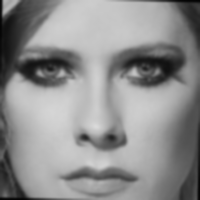

guess: leonardo-dicaprio    expected: avril_lavigne    distance: 118.426    angle: -1.469 °


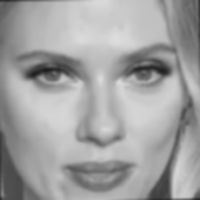

guess: leonardo-dicaprio    expected: scarlett_johanneson    distance: 72.365    angle: 0.725 °


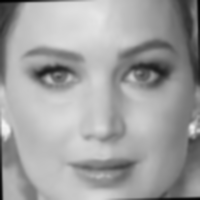

guess: amber-heard    expected: jennifer_lawrence    distance: 145.215    angle: 1.591 °


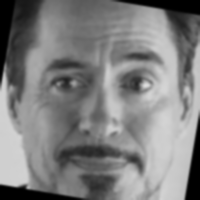

guess: alexandra-daddario    expected: robert_d_junior    distance: 193.708    angle: -9.605 °


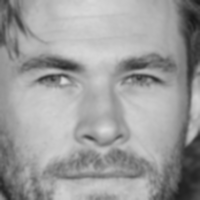

guess: alexandra-daddario    expected: chris_hemsworth    distance: 120.255    angle: -9.605 °


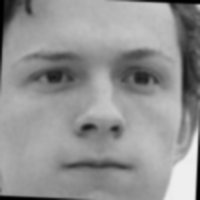

guess: chris-pratt    expected: tom_holland    distance: 155.086    angle: -2.564 °


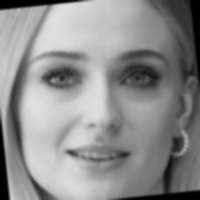

guess: andy-samberg    expected: sophie_turner    distance: 151.075    angle: 5.964 °


In [ ]:
cap = cv2.VideoCapture(0)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
recognizer= cv2.face.FisherFaceRecognizer_create()
recognizer.read("/content/drive/MyDrive/CV_Project/recognizers/face-trainer-Fisher.yml")

labels = {"person_name": 1}
with open("/content/drive/MyDrive/CV_Project/pickles/face-labels-Fisher.pickle", 'rb') as f:
  og_labels = pickle.load(f)
  labels = {v: k for k, v in og_labels.items()}

BASE_DIR = os.path.dirname("/content/drive/MyDrive/CV_Project/camera Fisher.ipynb")
image_dir = os.path.join(BASE_DIR, "test_images")
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith("png") or file.endswith("jpg"):
            path = os.path.join(root, file)

            frame = cv2.imread(path)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) != 0:
                for (x, y, width, height) in faces:
                    cv2.rectangle(frame, (x, y), (x + width, y + height),
                                (255, 255, 255), 3)
                    roi_gray = gray[y:y+height, x:x+width]
                    roi_res = cv2.resize(roi_gray, (200,200), interpolation=cv2.INTER_AREA)
                  
                    for (x, y, width, height) in faces:
                      eyes = eye_cascade.detectMultiScale(roi_gray[y:(y + height), x:(x + width)], 1.3, 6)
                      index = 0
                      eye_1 = [None, None, None, None]
                      eye_2 = [None, None, None, None]
                      for (ex, ey, ew, eh) in eyes:
                            if index == 0:
                                eye_1 = [ex, ey, ew, eh]
                            elif index == 1:
                                eye_2 = [ex, ey, ew, eh]
                            cv2.rectangle(roi_gray[y:(y + height), x:(x + width)], (ex, ey),
                                        (ex + ew, ey + eh), (0, 255, 0), 1)
                            index = index + 1
                            if (eye_1[0] is not None) and (eye_2[0] is not None):
                                if eye_1[0] < eye_2[0]:
                                    left_eye = eye_1
                                    right_eye = eye_2
                                else:
                                    left_eye = eye_2
                                    right_eye = eye_1
                                left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))

                                right_eye_center = (int(right_eye[0] + (right_eye[2] / 2)), int(right_eye[1] + (right_eye[3] / 2)))

                                left_eye_x = left_eye_center[0]
                                left_eye_y = left_eye_center[1]
                                right_eye_x = right_eye_center[0]
                                right_eye_y = right_eye_center[1]

                                delta_x = right_eye_x - left_eye_x
                                delta_y = right_eye_y - left_eye_y

                                if delta_x != 0:
                                  angle = np.arctan(delta_y / delta_x)

                                # Converting radians to degrees
                                angle = (angle * 180) / np.pi

                                if angle > 5:
                                    image_center = tuple(np.array(roi_res.shape[1::-1]) / 2)
                                    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
                                    result = cv2.warpAffine(roi_res, rot_mat, roi_res.shape[1::-1], flags=cv2.INTER_LINEAR)
                                    roi_res=result
                                elif angle < -5:
                                    image_center = tuple(np.array(roi_res.shape[1::-1]) / 2)
                                    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
                                    result = cv2.warpAffine(roi_res, rot_mat, roi_res.shape[1::-1], flags=cv2.INTER_LINEAR)
                                    roi_res=result
                                else:
                                    image_center = tuple(np.array(roi_res.shape[1::-1]) / 2)
                                    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
                                    result = cv2.warpAffine(roi_res, rot_mat, roi_res.shape[1::-1], flags=cv2.INTER_LINEAR)
                                    roi_res=result

                    roi_res=cv2.GaussianBlur(roi_res,(5,5),1)
                    cv2_imshow(roi_res)

                    id_, conf = recognizer.predict(roi_res) #conf = distance of the face from the training set (euclidean)
                    if conf >= 4 and conf <= 300:
                      name = labels[id_]
                      print("guess:", name[5:], "  ", "expected:", file[:-4] ,"  ", "distance:", round(conf,3), "  ", "angle:", round(angle,3), "°")
                    else:
                        name = "unknown"
                        print(name, "  ", "expected:", file[:-4])